# 강화학습 구현과 실현

강화학습에는 여러 기법이 있는데 여기에서는 DQN(Deep Q-Network)를 사용하여 강화학습을 진행하였습니다  
DQN은 기존의 Q-Learning에 신경망을 결합한 것입니다  
Q-Learning은 주어진 상태에서 행동을 수행하면서 미래의 효율적인 기댓값을 예측하는 Q 함수를 학습하면서 최적의 정책을 학습히는 기법입니다  

여기서는 DQN을 이용하여 떨어지는 블럭을 바(bar)로 받아내는 간단한 블럭 받기 게임을 학습시켜 에이전트에게 게임을 플레이 시킬 것입니다  

## 설치

In [5]:
!pip install tensorflow
!pip install matplotlib

zsh:1: command not found: pip
zsh:1: command not found: pip


## import

In [34]:
import tensorflow as tf
import numpy as np
import random
import math
import os
tf.compat.v1.disable_eager_execution()
# tensorflow v2에서 사용법인 바뀐 함수들은 앞에 tf.compat.v1.를 붙여서 사용해준다

## 파라미터 설정

In [35]:
epsilon = 1  # 랜덤하게 행동할 확률
epsilonMinimumValue = 0.001  # epsilon의 최소값
nbActions = 3  # 행동의 개수 (왼쪽, 대기, 오른쪽)
epoch = 1001  # 게임 반복횟수
hiddenSize = 100  # 히든 레이어 뉴런 개수
maxMemory = 500  # 게임내용을 기억하는 최대 개수
batchSize = 50  # 학습시 데이터 묶음 개수
gridSize = 10  # 게임 화면 크기
nbStates = gridSize * gridSize  # 상태 개수 (게임 화면 픽셀의 개수)
discount = 0.9  # 감소값
learningRate = 0.2  # 학습률

## 딥러닝 모델 설정
입력레이어는 nbStates(100)개 히든레이어는 hiddenSize(100)개 출력레이어는 nbAction(3)개를 가지는 딥러닝 모델을 만들어 준다  
CNN을 사용한다  

### 입력 레이어
**X = tf.compat.v1.placeholder(tf.float32, [None, nbStates]) # 입력값**  
placeholder는 변수를 선언할 때 값을 바로 주는 것이 아닌 나중에 값을 던져줄 수 있도록 공간을 미리 만들어 주는 것이다  
따라서 X는 데이터 유형이 float32이고 첫번째 차원의 수는 정해져있지 않고(가변적) 두번째 차원의 수는 nbStates의 값을 가지는 placeholder가 된다  

**W1 = tf.Variable(tf.random.truncated_normal([nbStates, hiddenSize], stddev=1.0 / math.sqrt(float(nbStates)))) # 가중치**  
입력 레이어의 가중치를 나타내는 W1을 생성해 준다  
변수의 초기화는 랜덤값으로 주어지는데 이 랜덤값은 양쪽 끝이 잘려있는 정규분포에서 가져오게 된다
이 정규분포의 표준편차는 $\frac{1}{\sqrt{nbStates}}$가 된다  
이러한 랜덤값들로 nbStates x hiddenSize의 크기를 가지는 행렬을 채워준다  

**b1 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향**  
활성화 난이도를 조절해주는 b1을 생성해준다  
학습데이터가 가중치와 계산되어 나온 값에 더해주어 활성화 난이도를 조절해주는 역할을 해준다  
여기서도 양쪽 끝이 잘려있는 정규분포를 이용하게 되는데 이 정규분포의 표준편차는 0.01이 된다  
hiddenSize개의 랜덤값들을 만들어준다  

**input_layer = tf.nn.relu(tf.matmul(X, W1) + b1)**  
input layer의 출력값을 만들어준다  
우선 X과 W1의 행렬곱을 한 다음 b1을 더해준다  
그 다음 활성화 함수에 넣어주는데 여기서 활성화 함수는 ReLU 함수가 사용된다  
ReLU 함수: $f(x) = max(0,x)$  

입력값인 X와 가중치인 W1을 행렬곱을 하게 되면 X는 None x nbStates의 크기를 가지는 행렬이고 W1은 nbStates x hiddenSize의 크기를 가지는 행렬이므로 결과는 None x hiddenSize의 크기를 가지는 행렬이 나오게 된다  
이렇게 행렬곱을 하게되면 각각의 입력 레이어 노드에 들어가는 입력값들을 만들어낼 수 있다  
이 값에 편향인 b1을 더해준 뒤 활성화 함수에 넣어주면 각각의 입력 레이어 노드의 출력값들을 만들어낼 수 있다

In [36]:
X = tf.compat.v1.placeholder(tf.float32, [None, nbStates]) # 입력값
W1 = tf.Variable(tf.random.truncated_normal([nbStates, hiddenSize], stddev=1.0 / math.sqrt(float(nbStates)))) # 가중치
b1 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향
input_layer = tf.nn.relu(tf.matmul(X, W1) + b1) # 출력값

### 히든 레이어
**W2 = tf.Variable(tf.random.truncated_normal([hiddenSize, hiddenSize],stddev=1.0 / math.sqrt(float(hiddenSize))))**  
히든 레이어의 가중치를 나타내는 W2를 생성해준다
입력 레이어와 마찬가지로 변수의 초기화는 랜덤값으로 주어지는데 이 랜덤값은 양쪽 끝이 잘려있는 정규분포에서 가져오게 된다  
이 정규분포의 표준편차는 $\frac{1}{\sqrt{hiddenSize}}$가 된다  
이러한 랜덤값들로 hiddenSize x hiddenSize의 크기를 가지는 행렬을 채워준다  

**b2 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향**  
활성화 난이도를 조절해주는 b2을 생성해준다  
입력 레이어와 마찬가지로 학습데이터가 가중치와 계산되어 나온 값에 더해주어 활성화 난이도를 조절해주는 역할을 해준다  
여기서도 양쪽 끝이 잘려있는 정규분포를 이용하게 되는데 이 정규분포의 표준편차는 0.01이 된다  
hiddenSize개의 랜덤값들을 만들어준다  

**hidden_layer = tf.nn.relu(tf.matmul(input_layer, W2) + b2) # 출력값**  
hidden layer의 출력값을 만들어준다  
우선 input_layer(입력 레이어의 출력값)과 W2의 행렬곱을 한 다음 b2을 더해준다  
그 다음 활성화 함수에 넣어주는데 여기서도 활성화 함수는 ReLU 함수가 사용된다  
ReLU 함수: $f(x) = max(0,x)$  

입력 레이어의 출력값인 input_layer와 가중치인 W2을 행렬곱을 하게 되면 input_layer는 None x hiddenSize 크기를 가지는 행렬이고 W2은 hiddenSize x hiddenSize의 크기를 가지는 행렬이므로 결과는 None x hiddenSize의 크기를 가지는 행렬이 나오게 된다  
이렇게 행렬곱을 하게되면 각각의 히든 레이어 노드에 들어가는 입력값들을 만들어낼 수 있다  
이 값에 편향인 b2을 더해준 뒤 활성화 함수에 넣어주면 각각의 히든 레이어 노드의 출력값들을 만들어낼 수 있다

In [37]:
W2 = tf.Variable(tf.random.truncated_normal([hiddenSize, hiddenSize],stddev=1.0 / math.sqrt(float(hiddenSize)))) # 가중치
b2 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향
hidden_layer = tf.nn.relu(tf.matmul(input_layer, W2) + b2) # 출력값

### 출력 레이어  
**W3 = tf.Variable(tf.random.truncated_normal([hiddenSize, nbActions],stddev=1.0 / math.sqrt(float(hiddenSize))))**  
출력 레이어의 가중치를 나타내는 W3을 생성해준다  
히든 레이어와 마찬가지로 변수의 초기화는 랜덤값으로 주어지는데 이 랜덤값은 양쪽 끝이 잘려있는 정규분포에서 가져오게 된다  
이 정규분포의 표준편차는 $\frac{1}{\sqrt{hiddenSize}}$가 된다  
이러한 랜덤값들로 hiddenSize x hiddenSize의 크기를 가지는 행렬을 채워준다  

**b3 = tf.Variable(tf.random.truncated_normal([nbActions], stddev=0.01))**  
활성화 난이도를 조절해주는 b3을 생성해준다  
히든 레이어와 마찬가지로 학습데이터가 가중치와 계산되어 나온 값에 더해주어 활성화 난이도를 조절해주는 역할을 해준다  
여기서도 양쪽 끝이 잘려있는 정규분포를 이용하게 되는데 이 정규분포의 표준편차는 0.01이 된다  
bnActions개의 랜덤값들을 만들어준다   

**output_layer = tf.matmul(hidden_layer, W3) + b3**  
out layer의 출력값을 만들어준다
hidden_layer(히든레이어의 출력값)과 W3의 행렬곱을 한 다음 b3을 더해준다  
회귀 문제이기 때문에 출력 레이어에서는 활성화 함수를 사용하지 않습니다 (항등함수라고도 함)

히든 레이어의 출력값인 hidden_layer와 가중치인 W3을 행렬곱을 하게 되면 hidden_layer는 None x hiddenSize 크기를 가지는 행렬이고 W3은 hiddenSize x nbActions 크기를 가지는 행렬이므로 결과는 None x nbActions 크기를 가지는 행렬이 나오게 된다  
이렇게 행렬곱을 하게되면 각각의 출력 레이어 노드에 들어가는 입력값들을 만들어낼 수 있다  
이 값에 편향인 b3을 더해주면 각각의 출력 레이어 노드의 출력값들을 만들어낼 수 있다  

In [38]:
W3 = tf.Variable(tf.random.truncated_normal([hiddenSize, nbActions],stddev=1.0 / math.sqrt(float(hiddenSize)))) # 가중치
b3 = tf.Variable(tf.random.truncated_normal([nbActions], stddev=0.01)) # 편향 
output_layer = tf.matmul(hidden_layer, W3) + b3 # 출력값

### 목표값 플레이스홀더
목표값 플레이스홀더 Y를 생성한다  
Y는 데이터 유형이 float32이고 첫번째 차원의 수는 정해져있지 않고(가변적) 두번째 차원의 수는 nbActions의 값을 가지는 placeholder가 된다  

In [39]:
Y = tf.compat.v1.placeholder(tf.float32, [None, nbActions])

### 목표값과 출력값의 차이인 코스트
목표값과 출력값의 오차를 구하기 위해 여기서는 평균 제곱 오차를 사용한다  
목표값(Y)에서 출력값(output_layer)을 뺀 다음 제곱을 해준다  
그 다음 나온 값들을 모두 더해준 뒤 2 x batchSize로 나누어준다  
batchSize는 한 번에 모델이 학습하는 데이터 샘플의 개수로 이렇게 2 x batchSize로 나누어주게 되면 코스트를 정규화해주게 된다  
정규화를 통해 학습률과 batchSize에 따른 코스트 크기의 영향을 줄일 수 있다

In [40]:
cost = tf.reduce_sum(tf.square(Y-output_layer)) / (2*batchSize)

### 경사하강법으로 코스트가 최소가 되는 값 찾음
경사하강법을 이용해 비용이 최소가 되는 값을 찾아준다  
경사하강법을 사용할 때 학습률은 learningRate가 되고 minimize(cost)를 붙여주어 cost를 최소화하도록 설정해준다  

In [41]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learningRate).minimize(cost)

## 랜덤값 함수
함수 randf는 s이상 e미만의 값을 가지는 float형태의 랜덤값을 리턴해준다  
(float(random.randrange(0, (e - s) * 9999)) / 10000) + s;
random.randrange는 0부터 (e - s) * 9999 미만의 랜덤값을 만들어준다  
이 값에 float를 붙여 실수로 변환해준 다음 10000으로 나누어주면 0이상 (e - s)미만의 랜덤값이 나오게 된다  
여기에 s를 더해주면 s이상 e미만의 랜덤값이 된다  

In [42]:
def randf(s, e):
    return (float(random.randrange(0, (e - s) * 9999)) / 10000) + s;

## 환경 클래스
### \_\_init__ 함수
\_\_init__ 함수는 초기화를 시켜준다  

**self.gridSize = gridSize  
self.nbStates = self.gridSize * self.gridSize  
self.state = np.empty(3, dtype = np.uint8)**  
np.empty는 초기화되지 않은 값으로 배열을 생성해주는 함수로 여기서는 길이가 3인 초기화되지 않은 배열이 생성된다  
배열의 데이터 형식은 uint8(부호 없는 8비트 정수)가 된다  

### observe 함수
observe 함수는 화면정보를 리턴해준다 (관찰)  

**canvas = self.drawState()**  
drawState함수의 출력값을 canvas에 저장해준다  

**canvas = np.reshape(canvas, (-1,self.nbStates))**  
np.reshape는 배열을 재구성해주는 함수로 여기서는 canvas 배열을 self.nbStates개의 열을 가지는 배열로 재구성해준다(행의 개수는 -1로 설정되어 있으므로 자동으로 결정된다)  
그 값을 다시 canvas에 저장해준다    

return canvas  
canvas를 리턴해준다  

### drawState 함수
drawState 함수는 블럭과 바를 표시하여 화면정보를 리턴해준다

**canvas = np.zeros((self.gridSize, self.gridSize))**  
모든 요소가 0으로 초기화된 self.gridSize x self.gridSize의 크기를 가지는 배열을 생성한다  

**canvas[self.state[0]-1, self.state[1]-1] = 1**  
self.state는 길이가 3인 배열로 0에는 블럭의 행번호가 1에는 블럭의 열번호를 저장하고 있다  
self.state 값들을 계산할때는 gridSize를 기준으로 계산을 해 1 ~ gridSize이지만 실제로 나타낼 때는 0 ~ gridSize-1이기 때문에 각 값들에 -1을 해준 위치의 배열값을 1로 바꾸어준다   

**canvas[self.gridSize-1, self.state[2] -1 - 1] = 1  
canvas[self.gridSize-1, self.state[2] -1] = 1  
canvas[self.gridSize-1, self.state[2] -1 + 1] = 1**  
self.State[2]에는 바의 열번호를 저장하고 있다  
따라서 바의 행번호는 self.gridSize-1(가장 마지막 행)을 해주고 열번호는 self.state[2]-1과 좌우 배열값들을 1로 바꾸어준다    

return canvas  
canvas를 리턴해준다  

### reset 함수
reset함수는 블럭과 바의 위치를 리셋해준다  

**initialFruitColumn = random.randrange(1, self.gridSize + 1)**  
1이상 self.gridSize+1 미만의 랜덤값을 initialFruitColumn에 저장해준다  

**initialBucketPosition = random.randrange(2, self.gridSize + 1 - 1)**  
2이상 self.gridSize미만의 랜덤값을 initialBucketPosition에 저장해준다  
바는 양옆에 픽셀까지 사용하기 때문에 블럭과 다르게 2이상 self.gridSize미만으로 설정해준다  

**self.state = np.array([1, initialFruitColumn, initialBucketPosition])**  
블럭의 시작은 항상 맨 위이여야 하기 때문에 self.state[0]은 1로 설정해주고 self.state[1]에는 블럭의 열번호인 initialFruitColumn로 설정해주고 self.state[2]에는 바의 위치인 initialBucketPosition을 설정해준다(바는 항상 행번호가 마지막 행번호로 정해져있기 때문에 열번호만 변경해주면 된다)

**return self.getState()**  
self.getState(현재 상태)를 리턴해준다

### getState 함수  
getState 함수는 현재 상태를 리턴해준다  

**stateInfo = self.state**  
stateInfo에 현재 state값을 불러온 뒤   

**fruit_row = stateInfo[0]**  
블럭의 행번호는 fruit_row에 저장  

**fruit_col = stateInfo[1]**  
블럭의 열번호는 fruit_col에 저장  

**basket = stateInfo[2]**  
바의 위치는 basket에 저장해준다  

**return fruit_row, fruit_col, basket**  
각각의 값들을 리턴해준다  

### getReward 함수  
getReward 함수는 보상값을 리턴해준다  

**fruitRow, fruitColumn, basket = self.getState()**  
우선 getState 함수를 이용해 현재 상태를 가져온다  

**if (fruitRow == self.gridSize - 1):**   # 만약 블럭의 행번호가 self.gridSize - 1 과 같다면 (블럭이 가장 마지막 행까지 갔다면)  
&nbsp;&nbsp;&nbsp;&nbsp;**if (abs(fruitColumn - basket) <= 1):**  # 블럭의 열번호 - 바의 위치에 절대값이 <= 1이라면 (0이라면 == 위치가 같다면)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**return 1**   # 1을 리턴해준다  
&nbsp;&nbsp;&nbsp;&nbsp;**else:**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**return -1**   # 위치가 같지 않다면 -1을 리턴해준다  
**else:**   # 블럭의 행번호가 gridSize - 1 과 같지 않다면 (블럭이 아직 가장 마지막 행까지 가지 않았다면)  
&nbsp;&nbsp;&nbsp;&nbsp;**return 0**   # 0을 리턴해준다**  

### isGameOver 함수
isGameOver 함수는 게임이 끝났는지의 여부를 리턴해준다   

**if (self.state[0] == self.gridSize - 1):**  # 만약 블럭의 행번호가 self.girdSize-1과 같다면 (블럭이 가장 마지막 행까지 갔다면)  
&nbsp;&nbsp;&nbsp;&nbsp;**return True** # True를 리턴해준다  
**else:** # 블럭이 가장 마지막 행까지 가지 않았다면  
&nbsp;&nbsp;&nbsp;&nbsp;**return False**  # False를 리턴해준다  
    
### updateState 함수
updateState 함수는 action에 따라 바의 위치를 업데이트해주고 블럭의 위치를 업데이트해준다

**if (action == 1):** # action이 1이면 왼쪽으로 이동시켜준다  
&nbsp;&nbsp;&nbsp;&nbsp;**action = -1**    
**elif (action == 2):** # action이 2이면 그대로 있는다  
&nbsp;&nbsp;&nbsp;&nbsp;**action = 0**   
**else:**  # action이 1이나 2가 아니면 오른쪽으로 이동시켜준다    
&nbsp;&nbsp;&nbsp;&nbsp;**action = 1**  

**fruitRow, fruitColumn, basket = self.getState()**  
getState함수를 이용해 현재상태를 가져온다  

**newBasket = min(max(2, basket + action), self.gridSize - 1)**  # 바 위치 변경  
새로운 바의 위치는 우선 2와 bascket + action 중 큰 것을 고른 다음 self.gridSize - 1과 비교하여 더 작은 값으로 설정해준다 (2이상 self.gridSize-1이하의 값으로 설정된다 바는 양옆의 픽셀까지 사용하기 때문에 2와 self.gridSize - 1로 설정해준다)  

**fruitRow = fruitRow + 1**  # 블럭을 아래로 이동  
블럭의 행번호도 하나 추가해준다  

**self.state = np.array([fruitRow, fruitColumn, newBasket])**  
state값을 새로운 값들로 업데이트 해준다  

### act 함수
act 함수는 행동을 수행한다  

**self.updateState(action)**  
updateState 함수를 사용해 바의 위치와 블럭의 위치를 업데이트 시켜준다  

**reward = self.getReward()**  
getReward 함수를 사용해 보상값을 가져오고  

**gameOver = self.isGameOver()**  
isGameOver 함수를 사용해 게임이 끝났는지 확인한다  

**return self.observe(), reward, gameOver, self.getState()**  
앞에서 가져온 값들을 리턴해준다  

In [43]:
class CatchEnvironment():
    # 초기화
    def __init__(self, gridSize):
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.state = np.empty(3, dtype = np.uint8) 
        
    # 화면정보 리턴
    def observe(self):
        canvas = self.drawState()
        canvas = np.reshape(canvas, (-1,self.nbStates))
        return canvas
    
    # 블럭과 바를 표시하여 화면정보 리턴
    def drawState(self):
        canvas = np.zeros((self.gridSize, self.gridSize))
    
        # 블럭 표시
        canvas[self.state[0]-1, self.state[1]-1] = 1

        # 바 표시
        canvas[self.gridSize-1, self.state[2] -1 - 1] = 1
        canvas[self.gridSize-1, self.state[2] -1] = 1
        canvas[self.gridSize-1, self.state[2] -1 + 1] = 1    
        return canvas 

    # 블럭과 바 위치 초기화
    def reset(self): 
        initialFruitColumn = random.randrange(1, self.gridSize + 1)
        initialBucketPosition = random.randrange(2, self.gridSize + 1 - 1)
        self.state = np.array([1, initialFruitColumn, initialBucketPosition]) 
        return self.getState()

    # 상태 리턴
    def getState(self):
        stateInfo = self.state
        fruit_row = stateInfo[0]
        fruit_col = stateInfo[1]
        basket = stateInfo[2]
        return fruit_row, fruit_col, basket

    # 보상값 리턴
    def getReward(self):
        fruitRow, fruitColumn, basket = self.getState()
        if (fruitRow == self.gridSize - 1):  # If the fruit has reached the bottom.
            if (abs(fruitColumn - basket) <= 1): # Check if the basket caught the fruit.
                return 1
            else:
                return -1
        else:
            return 0

    # 게임오버 검사
    def isGameOver(self):
        if (self.state[0] == self.gridSize - 1): 
            return True 
        else: 
            return False 

    # 상태 업데이트
    def updateState(self, action):
        if (action == 1):
            action = -1  # 왼쪽 이동
        elif (action == 2):
            action = 0  # 대기
        else:
            action = 1  # 오른쪽 이동
        fruitRow, fruitColumn, basket = self.getState()
        newBasket = min(max(2, basket + action), self.gridSize - 1)  # 바 위치 변경
        fruitRow = fruitRow + 1  # 블럭을 아래로 이동
        self.state = np.array([fruitRow, fruitColumn, newBasket])

    # 행동 수행 (1->왼쪽, 2->대기, 3->오른쪽)
    def act(self, action):
        self.updateState(action)
        reward = self.getReward()
        gameOver = self.isGameOver()
        return self.observe(), reward, gameOver, self.getState() 

## 메모리 클래스 (게임내용을 저장하고 나중에 배치로 묶어 학습에 사용)

### \_\_init__ 함수
\_\_init__ 함수는 초기화를 시켜준다  

**self.maxMemory = maxMemory  
self.gridSize = gridSize  
self.nbStates = self.gridSize * self.gridSize  
self.discount = discount  
canvas = np.zeros((self.gridSize, self.gridSize))**  
canvas는 0으로 초기화된 self.gridSize x self.gridSize의 크기를 가지는 배열이 된다  

**canvas = np.reshape(canvas, (-1,self.nbStates))**  
위에서 생성한 canvas를 self.nbStates개의 열을 가지는 배열로 재배열해준다  

**self.inputState = np.empty((self.maxMemory, 100), dtype = np.float32)**  
self.inputState는 초기화가 되지 않은 self.maxMermory * 100의 크기를 가지는 배열이 된다  
배열의 데이터 형식은 np.float32가 된다  

**self.actions = np.zeros(self.maxMemory, dtype = np.uint8)**  
self.actions는 0으로 초기화된 self.maxMemory의 길이를 가지는 배열이 된다
배열의 데이터 형식은 np.uint8이 된다

**self.nextState = np.empty((self.maxMemory, 100), dtype = np.float32)**  
self.nextState는 초기화가 되지 않은 self.maxMemory x 100의 크기를 가지는 배열이 된다  
배열의 데이터 형식은 np.float32가 된다

**self.gameOver = np.empty(self.maxMemory, dtype = np.bool_)**  
self.gameOver는 초기화가 되지 않은 self.maxMemory의 길이를 가지는 배열이 된다  
배열의 데이터 형식은 np.bool_이 된다

**self.rewards = np.empty(self.maxMemory, dtype = np.int8)**  
self.rewords는 초기화가 되지 않은 self.maxMemory의 길이를 가지는 배열이 된다  
배열의 데이터 형식은 np.int8이 된다  

**self.count = 0  
self.current = 0**  

### remember 함수
remember 함수는 경험을 ReplayMemory에 저장해준다  

**self.actions[self.current] = action**  
self.actions의 self.current번째 데이터는 action이 된다  

**self.rewards[self.current] = reward**  
self.rewards의 self.current번째 데이터는 reward가 된다  

**self.inputState[self.current, ...] = currentState**  
self.inputState의 self.current번째 행의 데이터는 currentState가 된다  

**self.nextState[self.current, ...] = nextState**   
self.nextState의 self.current번째 행의 데이터는 nextState가 된다  

**self.gameOver[self.current] = gameOver**  
self.gameOver의 self.current번째 데이터는 gameOver가 된다  

**self.count = max(self.count, self.current + 1)**  
self.count는 self.count와 self.current+1 중 더 큰 값이 된다  
현재까지 사용된 데이터의 수를 업데이트해준다

**self.current = (self.current + 1) % self.maxMemory**  
self.current는 self.current + 1을 self.maxMemory로 나눈 나머지값이 된다  
이렇게 해주는 이유는 self.current + 1이 self.maxMemory 값과 같아질 경우 0으로 만들어 주기 때문이다  
따라서 self.current는 0에서 self.maxMemory -1의 값을 가지게 된다  

### getBatch 함수
getBatch 함수는 저장된 게임내용에서 랜덤한 배치(batch)를 가져오는 함수입니다  
배치(batch)는 한 번에 모델에 입력되는 데이터의 묶음을 말합니다  

**memoryLength = self.count**  
memoryLength는 self.count(현재까지 사용된 데이터의 수)가 된다  

**chosenBatchSize = min(batchSize, memoryLength)**  
chosenBatchSize는 batchSize와 memoryLength 중 더 작은 값이 된다  

**inputs = np.zeros((chosenBatchSize, nbStates))**   
inputs은 0으로 초기화된 chosenBatchSize x nbStates의 크기를 가지는 배열이 된다  

**targets = np.zeros((chosenBatchSize, nbActions))**   
targets은 0으로 초기화된 chosenBatchSize x nbActions의 크기를 가지는 배열이 된다  

**for i in range(chosenBatchSize):** 
chosenBatchSize만큼 for문을 돌려준다  

**randomIndex = random.randrange(0, memoryLength)**  
randomIndex는 0이상 memoryLength 이하의 랜덤값을 가지게 된다  

**current_inputState = np.reshape(self.inputState[randomIndex], (1, 100))**  
current_inputState는 inputState의 randomIndex번째 행의 데이터를 1 x 100 크기의 배열로 재배열해준다  

**target = sess.run(model, feed_dict={X: current_inputState})**  
target은 tensorflow의 세션을 실행한 뒤 model을 설정해주고 X는 모델의 입력 플레이스홀더를 나타내고 current_inputState가 이 플레이스홀더에 입력이 된다  
그 다음 모델을 실행하여 그 결과를 받을 수 있다  
Q값을 불러온다  

**current_nextState = np.reshape(self.nextState[randomIndex], (1, 100))**  
current_nextState는 nextState의 randomIndex번째 행의 데이터를 1 x 100 크기의 배열로 재배열해준다  

**current_outputs = sess.run(model, feed_dict={X: current_nextState})**       
그 다음 target과 마찬가지로 세션을 실행한 다음 결과를 받는데 여기서는 플레이스홀더에 입력되는 값이 current_nextState로 바뀐다  

**nextStateMaxQ = np.amax(current_outputs)**   
nextStateMaxQ는 current_outputs에서 최대값을 가진다  
다음 상태에서 가질 수 있는 가장 큰 Q값을 계산


**if (self.gameOver[randomIndex] == True):**  # 만약 gameOver의 randomIndex번째 행의 값이 True라면 (게임이 끝났다면)  
&nbsp;&nbsp;&nbsp;&nbsp;**target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex]** # target의 첫번째 행의 self.actions의 randomIndex번째 데이터 - 1번째 열의 데이터는 self.rewards의 randomIndex번째 데이터가 된다  
게임이 끝났을 때의 Q값은 reward(보상값)이 된다  

**else:**  # 만약 gameOver의 randomIndex 행의 값이 False라면 (게임이 끝나지 않았다면)  
&nbsp;&nbsp;&nbsp;&nbsp;**target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex] +self.discount * nextStateMaxQ**  
True일때와 마찬가지로 self.reward의 데이터를 넣어주는데 이번에는 reward(보상값)에 self.discount(감소값) x nextStateMaxQ(가질 수 있는 가장 큰 Q값)을 더해준다  
Q값을 업데이트 시켜주는 과정인데 Q-Learning의 업데이트 수식은 보상값 + 감소값 x maxQ(상태,행동)입니다  

**inputs[i] = current_inputState**  
**targets[i] = target**  
**return inputs, targets**  
for문이 끝나면 저장한 input과 targets을 리턴해준다  

In [44]:
class ReplayMemory:

    # 초기화
    def __init__(self, gridSize, maxMemory, discount):
        self.maxMemory = maxMemory
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.discount = discount
        canvas = np.zeros((self.gridSize, self.gridSize))
        canvas = np.reshape(canvas, (-1,self.nbStates))
        self.inputState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.actions = np.zeros(self.maxMemory, dtype = np.uint8)
        self.nextState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.gameOver = np.empty(self.maxMemory, dtype = np.bool_)
        self.rewards = np.empty(self.maxMemory, dtype = np.int8) 
        self.count = 0
        self.current = 0

    # 게임내용 추가
    def remember(self, currentState, action, reward, nextState, gameOver):
        self.actions[self.current] = action
        self.rewards[self.current] = reward
        self.inputState[self.current, ...] = currentState
        self.nextState[self.current, ...] = nextState
        self.gameOver[self.current] = gameOver
        self.count = max(self.count, self.current + 1)
        self.current = (self.current + 1) % self.maxMemory

    # 게임내용을 배치로 묶어서 리턴
    def getBatch(self, model, batchSize, nbActions, nbStates, sess, X):
        memoryLength = self.count
        chosenBatchSize = min(batchSize, memoryLength)
        inputs = np.zeros((chosenBatchSize, nbStates))
        targets = np.zeros((chosenBatchSize, nbActions))

        for i in range(chosenBatchSize):
            # 메모리에서 랜덤하게 선택
            randomIndex = random.randrange(0, memoryLength)
            current_inputState = np.reshape(self.inputState[randomIndex], (1, 100))
            target = sess.run(model, feed_dict={X: current_inputState})

            current_nextState = np.reshape(self.nextState[randomIndex], (1, 100))
            current_outputs = sess.run(model, feed_dict={X: current_nextState})      

            # 다음 상태의 최대 Q값
            nextStateMaxQ = np.amax(current_outputs)


            if (self.gameOver[randomIndex] == True):
                # 게임오버일때 Q값은 보상값으로 설정
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex]
            else:
                # Q값을 계산
                # reward + discount(gamma) * max_a' Q(s',a')
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex] +self.discount * nextStateMaxQ
                
            inputs[i] = current_inputState
            targets[i] = target
        return inputs, targets

##  메인함수
**print("Training new model")**  

**env = CatchEnvironment(gridSize)**  
env를 CatchEnvironment 클래스로 정의해준다  
변수값으로 gridSize(게임화면 한 면의 픽셀 수)를 넘겨준다  

**memory = ReplayMemory(gridSize, maxMemory, discount)**  
memory를 ReplayMemory 클래스로 정의해준다  
변수값으로 gridSize(게임화면 한 면의 픽셀 수), maxMemory(ReplayMemory 데이터의 최대크기), discount(감소값)를 넘겨준다  

**saver = tf.compat.v1.train.Saver()**  
모델과 파라미터를 저장하기 위해 saver을 설정해준다  
    
**winCount = 0**  
winCount는 0으로 초기화해준다  

**with tf.compat.v1.Session() as sess:**  
세션을 열고 사용한 후 자동으로 세션을 닫아주는 코드이다  
여기서 sess는 세션을 나타내는 객체가 된다  

**sess.run(tf.compat.v1.global_variables_initializer())** 
세션 내의 텐서플로우 변수들(tf.variables)을 초기화 시켜준다  

**for i in range(epoch):**  
epoch만큼 for문을 반복해준다  

**err = 0**  
한 번의 루프 동안 사용할 err 변수를 0으로 초기화 해준다  

**env.reset()**  
reset 함수를 사용하여 블럭과 바의 위치를 리셋해준다  
      
**isGameOver = False**  
isGameOver 변수의 루프 초기화 값을 False로 설정해준다  

**currentState = env.observe()**  
currentState는 observe 함수를 사용하여 현재 화면의 상태를 가져온다  
            
**while (isGameOver != True):**  
만약 게임이 끝나지 않았다면 (만약 게임이 끝난다면 while문이 풀리고 다시 for문으로 돌아가 게임을 재시작하게 된다)   

**action = -9999**   
action을 -9999로 설정해주고(초기화)    

**global epsilon**  
전역변수인 epsilon을 불러온다  
epsilon은 랜덤하게 행동할 확률을 말한다  
epsilon greedy 기법에 따라 action을 취하게 된다  

**if (randf(0, 1) <= epsilon):**  
randf 함수를 이용하여 float 형태의 0이상 1미만인 랜덤값을 가져온 뒤 epsilon과 비교하여 epsilon이 같거나 더 크다면(epsilon의 확률만큼 랜덤한 행동을 합니다)      

**action = random.randrange(1, nbActions+1)**  
action은 1이상 nbActions + 1 미만인 랜덤값을 가지게 된다  

**else:**  
반대로 epsilon 보다 랜덤값이 작게 나온다면 (1-epsilon의 확률만큼 greedy 기법에 따라 Q값을 기반으로 가장 높은 가치를 가진 행동을 선택한다)  

**q = sess.run(output_layer, feed_dict={X: currentState})**   
위에서 정의했던 딥러닝에 currentState를 입력값으로 넣어 돌려 q에 넣어준다    

**index = q.argmax()**  
**action = index + 1**  
딥러닝을 돌려 얻은 q값들 중 가장 큰 값에 1을 더하여 action으로 설정해준다    

**if (epsilon > epsilonMinimumValue):**  
만약 epsilon이 epsilonMinimumValue(epsilon의 최소값)보다 크다면  

**epsilon = epsilon * 0.999**  
epsilon의 값을 감소시켜준다 (랜덤으로 행동할 확률을 감소시킨다)  
이렇게 되면 학습 초반에는 랜덤으로 행동할 확률이 높고 학습이 진행될 수록 랜덤으로 행동할 확률이 줄어든다  
                
**nextState, reward, gameOver, stateInfo = env.act(action)**  
act 함수를 사용해 nextState, reward, gameOver, stateInfo를 얻어낸다  
act 함수를 사용하게 되면 우선 updateState 함수를 사용해 상태를 업데이트 해준다  
이때 updateState에 아까 얻은 action값을 넣어주게 된다  
nextState: observe 함수를 사용해 얻은 값으로 화면 정보를 리턴받는다  
reward: getReward 함수를 사용해 보상값을 리턴받는다  
gameOver: isGameOver 함수를 사용하여 게임의 종료 여부를 확인한다  
stateInfo: getState 함수를 사용하여 게임의 상태를 리턴받는다  

**if (reward == 1):**
만약 reward가 1이라면 (블럭이 마지막 행까지 갔을 때 바와 위치가 같다면(게임을 이겼다면))

**winCount = winCount + 1**  
winCount를 1 올려준다  

**memory.remember(currentState, action, reward, nextState, gameOver)**  
remember 함수를 사용해 경험을 Replay Memory에 저장해준다  

**currentState = nextState**  
현재 상태를 다음 상태(act함수를 실행한)로 업데이트 해준다  

**isGameOver = gameOver**  
게임 종료 여부를 업데이트 시켜준다  
                
**inputs, targets = memory.getBatch(output_layer, batchSize, nbActions, nbStates, sess, X)**  
getBatch 함수를 사용하여 Replay Memory에서 학습에 사용할 batch 데이터를 불러온다  
        
**\_, loss = sess.run([optimizer, cost], feed_dict={X: inputs, Y: targets})**   
세션에서 optimizer(경사하강법을 이용한 최적값)과 cost(오차)를 실행해 optimizer을 이용해 최적화된 cost를 만들어낸다  
가져온 batch 데이터를 이용해 입력값은 inputs을 타겟값은 targets로 설정한다  
optimizer 결과는 사용하지 않기 때문에 \_로 표시하고 cost 결과는 loss에 저장해준다  

**err = err + loss**  
err에 위에서 나온 결과인 loss를 더해준다  

**print("Epoch " + str(i) + ": err = " + str(err) + ": Win count = " + str(winCount) + " Win ratio = " + str(float(winCount)/float(i+1)\*100))**   
for문이 돌때마다 각각의 값들을 출력해준다  
Win ratio는 현재 winCount를 i+1(i는 0부터 시작하기 때문에 1을 더해준다)를 나눈값에 100을 곱해 나타내준다 

**save_path = saver.save(sess,'model')**  
만들어진 모델을 model이라는 이름으로 저장해준다 (현재 파일이 있는 경로에 저장된다)  

**print("Finish")**  

In [45]:
def main(_):
    print("Training new model")

    # 환경 정의
    env = CatchEnvironment(gridSize)

    # 메모리 정의
    memory = ReplayMemory(gridSize, maxMemory, discount)

    # 세이버 설정
    saver = tf.compat.v1.train.Saver()
    
    winCount = 0
    with tf.compat.v1.Session() as sess:   
        sess.run(tf.compat.v1.global_variables_initializer())

        for i in range(epoch):
            err = 0
            env.reset()
      
            isGameOver = False

            currentState = env.observe()
            
            while (isGameOver != True):
                action = -9999 

                # 랜덤으로 행동을 할지 Q값에 따라 행동할지 결정
                global epsilon
                if (randf(0, 1) <= epsilon):
                    action = random.randrange(1, nbActions+1)
                else:          
                    q = sess.run(output_layer, feed_dict={X: currentState})      
                    index = q.argmax()
                    action = index + 1

 

                # 랜덤으로 행동할 확률 감소
                if (epsilon > epsilonMinimumValue):
                  epsilon = epsilon * 0.999
                
                # 행동 수행
                nextState, reward, gameOver, stateInfo = env.act(action)

                # 승리 횟수 설정
                if (reward == 1):
                    winCount = winCount + 1

                # 메모리에 저장
                memory.remember(currentState, action, reward, nextState, gameOver)

                # 다음 상태 설정
                currentState = nextState
                isGameOver = gameOver
                
                # 입력과 출력 데이터 배치를 구함
                inputs, targets = memory.getBatch(output_layer, batchSize, nbActions, nbStates, sess, X)
        
                # 학습 수행
                _, loss = sess.run([optimizer, cost], feed_dict={X: inputs, Y: targets})  
                err = err + loss

            print("Epoch " + str(i) + ": err = " + str(err) + ": Win count = " + str(winCount) + " Win ratio = " + str(float(winCount)/float(i+1)*100))

        # 모델 세션 저장
        save_path = saver.save(sess,'model')

        print("Finish")

## 메인 함수 실행

In [46]:
if __name__ == '__main__':
    tf.compat.v1.app.run()

Training new model
Epoch 0: err = 0.006210632644069847: Win count = 0 Win ratio = 0.0
Epoch 1: err = 0.13175524293910712: Win count = 0 Win ratio = 0.0
Epoch 2: err = 0.17373778542969376: Win count = 0 Win ratio = 0.0
Epoch 3: err = 0.20777934463694692: Win count = 0 Win ratio = 0.0
Epoch 4: err = 0.20776284579187632: Win count = 0 Win ratio = 0.0
Epoch 5: err = 0.32736863382160664: Win count = 0 Win ratio = 0.0
Epoch 6: err = 0.35962055902928114: Win count = 0 Win ratio = 0.0
Epoch 7: err = 0.3084113756194711: Win count = 0 Win ratio = 0.0
Epoch 8: err = 0.2549772076308727: Win count = 0 Win ratio = 0.0
Epoch 9: err = 0.3277985155582428: Win count = 0 Win ratio = 0.0
Epoch 10: err = 0.3028283454477787: Win count = 0 Win ratio = 0.0
Epoch 11: err = 0.2646270878612995: Win count = 0 Win ratio = 0.0
Epoch 12: err = 0.2169065224006772: Win count = 0 Win ratio = 0.0
Epoch 13: err = 0.2877187002450228: Win count = 0 Win ratio = 0.0
Epoch 14: err = 0.22772240359336138: Win count = 0 Win rati

Epoch 106: err = 0.30662233009934425: Win count = 35 Win ratio = 32.71028037383177
Epoch 107: err = 0.28870732337236404: Win count = 35 Win ratio = 32.407407407407405
Epoch 108: err = 0.33229823410511017: Win count = 36 Win ratio = 33.02752293577982
Epoch 109: err = 0.28115597553551197: Win count = 36 Win ratio = 32.72727272727273
Epoch 110: err = 0.36406139843165874: Win count = 36 Win ratio = 32.432432432432435
Epoch 111: err = 0.32611602544784546: Win count = 37 Win ratio = 33.035714285714285
Epoch 112: err = 0.3743466604501009: Win count = 37 Win ratio = 32.743362831858406
Epoch 113: err = 0.28737848810851574: Win count = 37 Win ratio = 32.45614035087719
Epoch 114: err = 0.29839761927723885: Win count = 38 Win ratio = 33.04347826086956
Epoch 115: err = 0.30406877864152193: Win count = 39 Win ratio = 33.62068965517241
Epoch 116: err = 0.23837811313569546: Win count = 40 Win ratio = 34.18803418803419
Epoch 117: err = 0.25108332745730877: Win count = 40 Win ratio = 33.89830508474576
E

Epoch 206: err = 0.10722731286659837: Win count = 69 Win ratio = 33.33333333333333
Epoch 207: err = 0.11826739460229874: Win count = 70 Win ratio = 33.65384615384615
Epoch 208: err = 0.09756380598992109: Win count = 71 Win ratio = 33.97129186602871
Epoch 209: err = 0.09970212308689952: Win count = 72 Win ratio = 34.285714285714285
Epoch 210: err = 0.0896970983594656: Win count = 72 Win ratio = 34.12322274881517
Epoch 211: err = 0.11373890098184347: Win count = 72 Win ratio = 33.9622641509434
Epoch 212: err = 0.12616251967847347: Win count = 73 Win ratio = 34.27230046948357
Epoch 213: err = 0.11496576853096485: Win count = 74 Win ratio = 34.57943925233645
Epoch 214: err = 0.10464883083477616: Win count = 74 Win ratio = 34.418604651162795
Epoch 215: err = 0.10180452326312661: Win count = 74 Win ratio = 34.25925925925926
Epoch 216: err = 0.08428150555118918: Win count = 74 Win ratio = 34.10138248847927
Epoch 217: err = 0.12886298168450594: Win count = 74 Win ratio = 33.94495412844037
Epoc

Epoch 306: err = 0.07974411733448505: Win count = 128 Win ratio = 41.69381107491857
Epoch 307: err = 0.05425239587202668: Win count = 129 Win ratio = 41.883116883116884
Epoch 308: err = 0.06228772131726146: Win count = 130 Win ratio = 42.07119741100323
Epoch 309: err = 0.06191363325342536: Win count = 131 Win ratio = 42.25806451612903
Epoch 310: err = 0.05079396814107895: Win count = 132 Win ratio = 42.443729903536976
Epoch 311: err = 0.05655255145393312: Win count = 133 Win ratio = 42.628205128205124
Epoch 312: err = 0.0512783951126039: Win count = 134 Win ratio = 42.81150159744409
Epoch 313: err = 0.08246976998634636: Win count = 135 Win ratio = 42.99363057324841
Epoch 314: err = 0.06801556353457272: Win count = 136 Win ratio = 43.17460317460318
Epoch 315: err = 0.06591094098985195: Win count = 137 Win ratio = 43.35443037974683
Epoch 316: err = 0.07753805909305811: Win count = 138 Win ratio = 43.53312302839117
Epoch 317: err = 0.07643223414197564: Win count = 138 Win ratio = 43.39622

Epoch 404: err = 0.009385086013935506: Win count = 213 Win ratio = 52.59259259259259
Epoch 405: err = 0.008362300315639004: Win count = 214 Win ratio = 52.70935960591133
Epoch 406: err = 0.02717274078167975: Win count = 215 Win ratio = 52.825552825552826
Epoch 407: err = 0.022773829521611333: Win count = 216 Win ratio = 52.94117647058824
Epoch 408: err = 0.015608081128448248: Win count = 216 Win ratio = 52.81173594132029
Epoch 409: err = 0.015782252710778266: Win count = 217 Win ratio = 52.926829268292686
Epoch 410: err = 0.011688172642607242: Win count = 218 Win ratio = 53.04136253041363
Epoch 411: err = 0.013152395724318922: Win count = 219 Win ratio = 53.15533980582524
Epoch 412: err = 0.017532882280647755: Win count = 220 Win ratio = 53.26876513317191
Epoch 413: err = 0.02050428540678695: Win count = 221 Win ratio = 53.3816425120773
Epoch 414: err = 0.027175483002793044: Win count = 222 Win ratio = 53.493975903614455
Epoch 415: err = 0.022306436439976096: Win count = 223 Win ratio 

Epoch 500: err = 0.0023948850503074937: Win count = 297 Win ratio = 59.2814371257485
Epoch 501: err = 0.0018145096764783375: Win count = 298 Win ratio = 59.36254980079681
Epoch 502: err = 0.0013857138328603469: Win count = 298 Win ratio = 59.24453280318092
Epoch 503: err = 0.0021760021554655395: Win count = 299 Win ratio = 59.32539682539682
Epoch 504: err = 0.001949019031599164: Win count = 300 Win ratio = 59.4059405940594
Epoch 505: err = 0.0013624212224385701: Win count = 301 Win ratio = 59.48616600790514
Epoch 506: err = 0.0012734688425553031: Win count = 302 Win ratio = 59.56607495069034
Epoch 507: err = 0.0015045141335576773: Win count = 303 Win ratio = 59.645669291338585
Epoch 508: err = 0.002900242143368814: Win count = 303 Win ratio = 59.52848722986247
Epoch 509: err = 0.0017496722939540632: Win count = 304 Win ratio = 59.6078431372549
Epoch 510: err = 0.0020361694841994904: Win count = 305 Win ratio = 59.68688845401174
Epoch 511: err = 0.0025919596264429856: Win count = 306 Wi

Epoch 596: err = 0.000594989560340764: Win count = 388 Win ratio = 64.99162479061977
Epoch 597: err = 0.0008897867992345709: Win count = 389 Win ratio = 65.05016722408027
Epoch 598: err = 0.001039391327140038: Win count = 390 Win ratio = 65.1085141903172
Epoch 599: err = 0.0006647768677794375: Win count = 391 Win ratio = 65.16666666666666
Epoch 600: err = 0.0021510075184778543: Win count = 392 Win ratio = 65.22462562396007
Epoch 601: err = 0.0018337255678488873: Win count = 393 Win ratio = 65.28239202657808
Epoch 602: err = 0.0014407731359824538: Win count = 394 Win ratio = 65.33996683250415
Epoch 603: err = 0.001390943769365549: Win count = 395 Win ratio = 65.39735099337747
Epoch 604: err = 0.0024416425367235206: Win count = 396 Win ratio = 65.45454545454545
Epoch 605: err = 0.001946297867107205: Win count = 397 Win ratio = 65.51155115511551
Epoch 606: err = 0.002910954790422693: Win count = 398 Win ratio = 65.56836902800659
Epoch 607: err = 0.00223253318836214: Win count = 399 Win ra

Epoch 694: err = 0.0005747049362980761: Win count = 479 Win ratio = 68.92086330935253
Epoch 695: err = 0.0006537970475619659: Win count = 480 Win ratio = 68.96551724137932
Epoch 696: err = 0.0006782235941500403: Win count = 481 Win ratio = 69.01004304160688
Epoch 697: err = 0.0008597345222369768: Win count = 482 Win ratio = 69.05444126074498
Epoch 698: err = 0.0007955315450089984: Win count = 483 Win ratio = 69.09871244635193
Epoch 699: err = 0.00084668429553858: Win count = 484 Win ratio = 69.14285714285714
Epoch 700: err = 0.0006503501317638438: Win count = 484 Win ratio = 69.04422253922966
Epoch 701: err = 0.0008188547690224368: Win count = 485 Win ratio = 69.08831908831908
Epoch 702: err = 0.0007751389312034007: Win count = 486 Win ratio = 69.13229018492176
Epoch 703: err = 0.0005952297051408095: Win count = 487 Win ratio = 69.17613636363636
Epoch 704: err = 0.0005476305814227089: Win count = 488 Win ratio = 69.21985815602837
Epoch 705: err = 0.0005791563617094653: Win count = 489 

Epoch 790: err = 0.00027915268037759233: Win count = 562 Win ratio = 71.04930467762325
Epoch 791: err = 0.00046817903239571024: Win count = 563 Win ratio = 71.08585858585859
Epoch 792: err = 0.00034705427970038727: Win count = 564 Win ratio = 71.12232030264816
Epoch 793: err = 0.00037633102510881145: Win count = 565 Win ratio = 71.15869017632241
Epoch 794: err = 0.0003329607188788941: Win count = 566 Win ratio = 71.19496855345912
Epoch 795: err = 0.00025410450052731903: Win count = 567 Win ratio = 71.23115577889448
Epoch 796: err = 0.00040873733632906806: Win count = 568 Win ratio = 71.267252195734
Epoch 797: err = 0.0003541835340001853: Win count = 569 Win ratio = 71.30325814536342
Epoch 798: err = 0.0002780111644824501: Win count = 570 Win ratio = 71.33917396745932
Epoch 799: err = 0.00032884501342778094: Win count = 571 Win ratio = 71.375
Epoch 800: err = 0.00026417588014737703: Win count = 572 Win ratio = 71.4107365792759
Epoch 801: err = 0.0002290705633640755: Win count = 573 Win 

Epoch 886: err = 0.00020391595717228483: Win count = 654 Win ratio = 73.73167981961669
Epoch 887: err = 0.00020609735383914085: Win count = 655 Win ratio = 73.76126126126125
Epoch 888: err = 0.00023689644422120182: Win count = 655 Win ratio = 73.67829021372329
Epoch 889: err = 0.00013796327857562574: Win count = 656 Win ratio = 73.70786516853933
Epoch 890: err = 9.172611999019864e-05: Win count = 656 Win ratio = 73.62514029180696
Epoch 891: err = 0.0001798126618268725: Win count = 657 Win ratio = 73.65470852017937
Epoch 892: err = 0.000208109435334336: Win count = 658 Win ratio = 73.68421052631578
Epoch 893: err = 0.0001848524589149747: Win count = 659 Win ratio = 73.71364653243847
Epoch 894: err = 0.0002691387253435096: Win count = 660 Win ratio = 73.74301675977654
Epoch 895: err = 0.00012087272170901997: Win count = 661 Win ratio = 73.77232142857143
Epoch 896: err = 0.0001127467157857609: Win count = 662 Win ratio = 73.8015607580825
Epoch 897: err = 0.00010284115387548809: Win count 

Epoch 982: err = 0.00041453260428170324: Win count = 741 Win ratio = 75.38148524923703
Epoch 983: err = 0.00014785600797040388: Win count = 742 Win ratio = 75.40650406504065
Epoch 984: err = 0.00010620393527460692: Win count = 743 Win ratio = 75.43147208121827
Epoch 985: err = 0.0003430983842918067: Win count = 744 Win ratio = 75.45638945233266
Epoch 986: err = 0.00016104550604723045: Win count = 745 Win ratio = 75.48125633232016
Epoch 987: err = 9.831252100411803e-05: Win count = 745 Win ratio = 75.40485829959515
Epoch 988: err = 0.00029768000922558713: Win count = 746 Win ratio = 75.42972699696662
Epoch 989: err = 0.0002987210236824467: Win count = 747 Win ratio = 75.45454545454545
Epoch 990: err = 0.0004201586261842749: Win count = 748 Win ratio = 75.47931382441978
Epoch 991: err = 0.0002527479459786264: Win count = 749 Win ratio = 75.50403225806451
Epoch 992: err = 0.00024656833375047427: Win count = 750 Win ratio = 75.52870090634441
Epoch 993: err = 0.00013458837838697946: Win cou

SystemExit: 

# 플레이 & 시각화

## import

In [50]:
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab as pl
import time
import tensorflow as tf
import math
import os

## 파라미터 설정

In [51]:
gridSize = 10 # 게임을 플레이할 격자 크기
maxGames = 10 # 게임을 플레이할 횟수 
env = CatchEnvironment(gridSize) # 환경 설정 
winCount = 0    # 게임 승리 횟수 
loseCount = 0   # 게임 패배 횟수
numberOfGames = 0   # 게임 실행 횟수 

## 화면 설정
**ground = 1**
**plot = pl.figure(figsize=(12,12))**  
크기가 12 x 12인 figure를 생성  

**axis = plot.add_subplot(111, aspect='equal')**   
만들어진 figure에 subplot을 추가해준다  
111은 1행 1열의 1번이라는 의미 (figure 전체)
aspect='equal'은 축의 비율을 갖게 만들어준다  

**axis.set_xlim([-1, 12])**  
x축의 범위를 -1 ~ 12까지로 설정  

**axis.set_ylim([0, 12])**  
y축의 범위를 0 ~ 12까지로 설정  

## drawState 함수
drawState 함수는 현재 상태를 그려준다  

## 모델을 사용하여 게임 플레이
**saver = tf.compat.v1.train.Saver()**
**with tf.compat.v1.Session() as sess:**
세션을 실행시켜준다  
세션을 나타내는 객체는 sess가 된다  

**saver.restore(sess, 'model')**  
저장했었던 model을 불러온다  
**print('saved model is loaded!')**  

**while (numberOfGames < maxGames):**  
만약 numberOfGames가 maxGames 보다 작다면 게임을 플레이한다  

**numberOfGames = numberOfGames + 1**  
numberOfGames의 값을 1 더해준다  
    
**isGameOver = False**  
**fruitRow, fruitColumn, basket = env.reset()**  
**currentState = env.observe()**  
**drawState(fruitRow, fruitColumn, basket)**  
메인함수에서와 마찬가지로 값들을 초기화 시켜준다  
여기서 다른점은 reset 함수를 사용해 리셋한 값을 불러와 drawState 함수에 넣어 게임화면을 그려준다  

**while (isGameOver != True):**  
만약 게임이 끝나지 않았다면 (만약 게임이 끝났다면 while문이 풀리면서 위쪽 while문으로 이동해 게임을 재시작하게 된다)

**q = sess.run(output_layer, feed_dict={X: currentState})**  
위에서 정의했던 딥러닝에 currentState를 입력값으로 넣어 돌려 q에 넣어준다

**index = q.argmax()**  
**action = index + 1**  
딥러닝을 돌려 얻은 q값들 중 가장 큰 값에 1을 더하여 action으로 설정해준다  

**nextState, reward, gameOver, stateInfo = env.act(action)**  
act 함수를 사용해 nextState, reward, gameOver, stateInfo를 얻어낸다  
여기까지는 메인함수와 똑같이 작동한다  

**fruitRow = stateInfo[0]**  
**fruitColumn = stateInfo[1]**  
**basket = stateInfo[2]**  
여기서는 메인함수와 다르게 화면에 표시할 정보가 필요하기 때문에 stateInfo에서 각 정보들을 가져온다  
fruitRow(블럭의 행번호)  
fruitColumn(블럭의 열번호)  
basket(바의 위치)  

**if (reward == 1):**  
**winCount = winCount + 1**  
**elif (reward == -1):**  
**loseCount = loseCount + 1**  
만약 reward가 1이라면 winCount을 1 더해주고 reward가 -1이라면 loseCount를 1 더해준다  

**currentState = nextState**  
현재 상태를 다음 상태(act함수를 실행한)로 업데이트 해준다 

**isGameOver = gameOver**  
게임 종료 여부를 업데이트 시켜준다  

**drawState(fruitRow, fruitColumn, basket)**  
아까 가져온 정보들로 drawState 함수를 사용해 게임 화면을 그려준다  

**time.sleep(0.4)**  
다음 행동을 하기 전에 딜레이를 준다  

**display.clear_output(wait=True)**  
마지막 결과를 새로운 화면으로 표시하는 것이 아닌 그대로 표시하기 위해 사용  

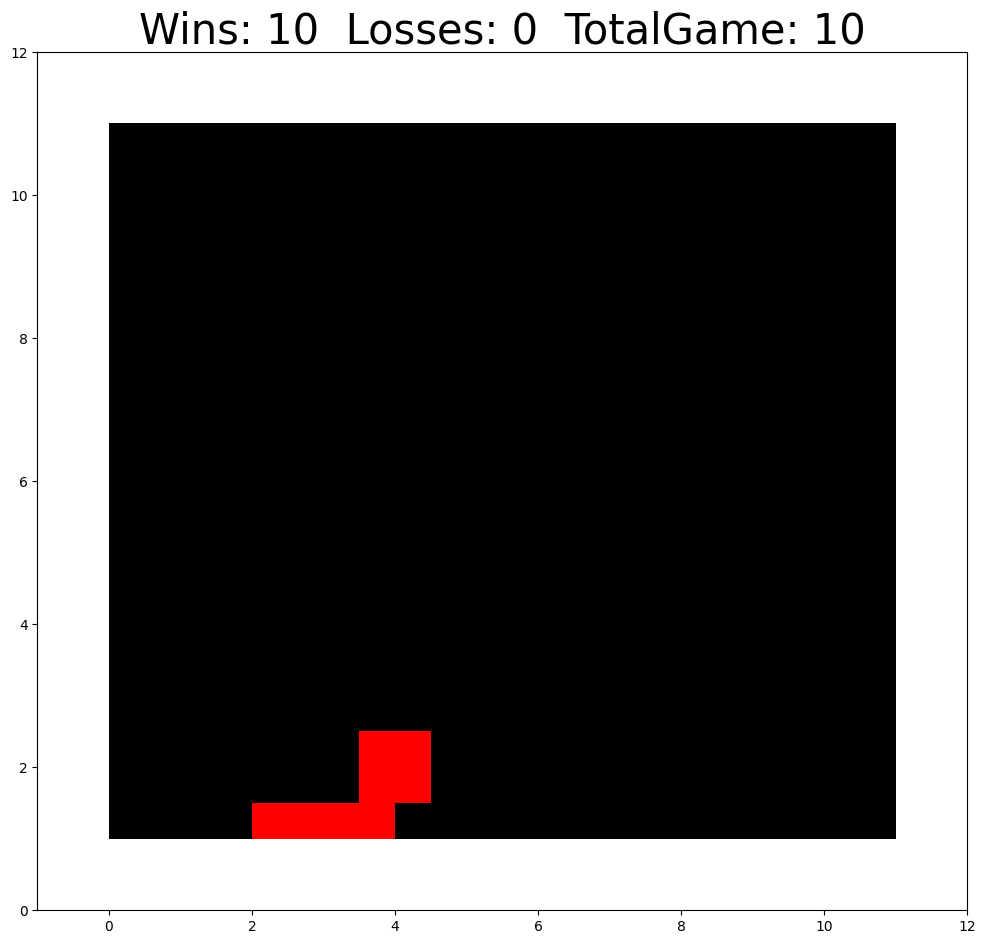

In [52]:
# 화면 설정 
ground = 1
plot = pl.figure(figsize=(12,12))
axis = plot.add_subplot(111, aspect='equal')
axis.set_xlim([-1, 12])
axis.set_ylim([0, 12])

# drawState 함수 
def drawState(fruitRow, fruitColumn, basket):
    global gridSize
    fruitX = fruitColumn 
    fruitY = (gridSize - fruitRow + 1)
    statusTitle = "Wins: " + str(winCount) + "  Losses: " + str(loseCount) + "  TotalGame: " + str(numberOfGames)
    axis.set_title(statusTitle, fontsize=30)
    for p in [
        patches.Rectangle(
            ((ground - 1), (ground)), 11, 10, facecolor="#000000"      # Black
        ),
        patches.Rectangle(
            (basket - 1, ground), 2, 0.5, facecolor="#FF0000"     # No background
        ),
        patches.Rectangle(
            (fruitX - 0.5, fruitY - 0.5), 1, 1, facecolor="#FF0000"       # red 
        ),   
        ]:
        axis.add_patch(p)
    display.clear_output(wait=True)
    display.display(pl.gcf())

# 모델을 사용하여 게임 플레이
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:    
    # model을 불러온다 
    saver.restore(sess, 'model')
    print('saved model is loaded!')

    while (numberOfGames < maxGames):
        numberOfGames = numberOfGames + 1
     
        # 초기화
        isGameOver = False
        fruitRow, fruitColumn, basket = env.reset()
        currentState = env.observe()
        drawState(fruitRow, fruitColumn, basket)

        while (isGameOver != True):
            q = sess.run(output_layer, feed_dict={X: currentState})
            # 가장 큰 Q값을 사용
            index = q.argmax()
            action = index + 1
            nextState, reward, gameOver, stateInfo = env.act(action)    
            fruitRow = stateInfo[0]
            fruitColumn = stateInfo[1]
            basket = stateInfo[2]
     
            # 게임 결과를 카운트
            if (reward == 1):
                winCount = winCount + 1
            elif (reward == -1):
                loseCount = loseCount + 1

            currentState = nextState
            isGameOver = gameOver
            drawState(fruitRow, fruitColumn, basket)
            time.sleep(0.4)

display.clear_output(wait=True)

## 정리 
여기서는 DQN을 이용하여 간단한 블럭 받기 게임을 학습시켰습니다  

우선 epsilon을 사용하여 랜덤으로 행동할지 Q값에 따라 행동할지 결정합니다  
랜덤으로 행동을 할 때에는 action값을 랜덤으로 주고 Q값에 따라 행동을 할 때에는 신경망에 현재 상태를 입력값으로 주고 나온 결과값들 중에서 가장 큰 값을 action값으로 설정합니다  
랜덤으로 행동할 확률인 epsilon은 학습이 진행될 수록 감소합니다  

그렇게 결정된 action을 수행하고 메모리에 action을 수행한 결과를 저장해 줍니다   

그 다음 메모리에서 데이터 묶음인 batch를 가져와 학습을 시켜줍니다  
inputs에는 입력값들이 들어있고 targets에는 보상값과 다음 상태의 최대 Q값이 더해진 값이 들어있습니다    
이제 이 inputs값이 딥러닝을 거쳐 나온 결과값과 targets값과의 오차가 최소가 될 수 있도록 경사하강법을 이용하여 학습시켜줍니다  

이러한 학습을 계속하게 되면 오차가 줄어들고 원하는 결과값을 얻을 수 있습니다    
